# Domain Generating Algorithms - Model / Feature Selection

Now that we've explored the data and developed a pipeline for generating features, let's identifying which type of classification model is up to the task.

There are a couple of considerations:
* Scoring, how well does the model generalise to data it was not trained particularly given the imbalanced nature of the data
* Complexity, is the model one that we can explain to people who may not have an understanding of model development but may be held accountable for the decisions made by the model.
* Time, how long does it take for the model to be fit

Depending on the siutation we can make different trade-offs on the above. I am assuming that priorities are in the order that they listed.

In [1]:
import os
from time import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Change our working directory so our project src import will work.

In [2]:
os.chdir("../")

In [3]:
! ls data

external
interim
processed
raw


Yes we are let's import the function we need to prepare our data.

## Reading in and Preprocessing Data

In [4]:
from src.preprocess import normalise_column

In [5]:
df = pd.read_csv("data/raw/dga_domains.csv")

In [6]:
len(df)

133926

In [7]:
df = df[["domain", "class"]]

In [8]:
df["domain"] = normalise_column(df["domain"])

In [9]:
df = df.dropna()

In [10]:
len(df)

114525

In [11]:
df.sample(10, random_state = 6)

,domain,class
132340,yravkfemaujp,dga
111813,thedailystar,legit
133702,zopguydozeumvnbayzdgadgypvx,dga
24819,chronofhorse,legit
62273,joydownload,legit
96165,rain-mail,legit
4,010shangpu,legit
104774,skyworth,legit
12691,apnicommunity,legit
128368,xctcyhlcqeapdmadcynrtt,dga


In [12]:
from src.features.transformers import CharacterCountTransformer
from src.features.transformers import CharacterVarietyRatioTransformer
from src.features.transformers import CharacterDistanceLeftRightTransformer
from src.features.transformers import CharacterRatioTransformer
from src.features.transformers import BinarizeCharacterPairsTransformer
from src.features.transformers import CountCharacterPairsTransformer
from src.features.transformers import TextLengthTransformer

In [13]:
from src.features import get_mode

Let's construct a Pipeline for generating some features we are interested in

In [14]:
generate_features = FeatureUnion([
    (
        "digit_ratio", 
        CharacterRatioTransformer(
            "digit_ratio", ["domain"], 
            [x for x in "1234567890"]
        )
    ),
    (
        "vowel_ratio", 
        CharacterRatioTransformer(
            "vowel_ratio", ["domain"], 
            [x for x in "aeiouy"]
        )
    ),
    (
        "vowel_distance_std_ratio",
        CharacterDistanceLeftRightTransformer(
            "vowel_distance_std_ratio", ["domain"], 
            [x for x in "aeiouy"], np.std, 
            True
        )
    ),
    (
        "vowel_distance_mode_ratio",
        CharacterDistanceLeftRightTransformer(
            "vowel_distance_mode_ratio", ["domain"], 
            [x for x in "aeiouy"], get_mode, 
            True
        )
    ),
    (
        "consonants_variety_ratio",
        CharacterVarietyRatioTransformer(
            "consonants_variety_ratio", ["domain"],
            [x for x in "aeiouy"]
        )
    ),
    (
        "len",
        TextLengthTransformer(
            "len", ["domain"],
        )
    )
])

In [15]:
pipeline = Pipeline([
    (
        "generate_features",
        generate_features
    ),
    (
        "standard_scaler",
        StandardScaler()
    ),
    (
        "pca",
        PCA(),
    ) 
])

We've previously limited the scope of the effort to only consider the `domain` and the `class` attrbiute.

In [16]:
X = df[["domain"]]
y = df["class"]

In [17]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
class_le.fit(y)
print(class_le.classes_)
np.save('label_class.npy', class_le.classes_)

['dga' 'legit']


In [18]:
y = class_le.transform(y)

In [19]:
new_X = pipeline.fit_transform(X)

Let's get our new column names

In [20]:
generated_feature_names = pipeline['generate_features'].get_feature_names()
generated_feature_names

['digit_ratio__domain_digit_ratio',
 'vowel_ratio__domain_vowel_ratio',
 'vowel_distance_std_ratio__domain_vowel_distance_std_ratio',
 'vowel_distance_mode_ratio__domain_vowel_distance_mode_ratio',
 'consonants_variety_ratio__domain_consonants_variety_ratio',
 'len__domain_len']

Let's inspect the explanatory power of our generated features.

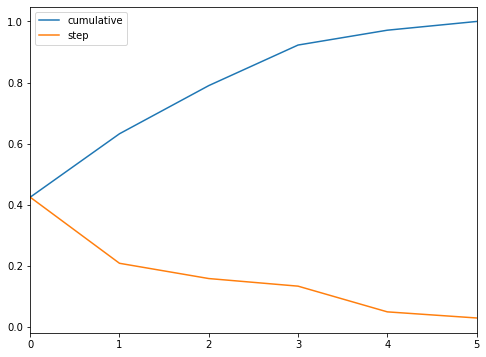

In [21]:
fig, ax = plt.subplots(figsize=(8,6))

pca_generated_features_df = pd.DataFrame(
    {
        "cumulative": pd.Series(pipeline['pca'].explained_variance_ratio_.cumsum()),
        "step": pd.Series(pipeline['pca'].explained_variance_ratio_),
    }
)

pca_generated_features_df.plot(ax = ax)

Let's look at the components and relate them back to our columns and determine which column has the most explanatory power.

In [22]:
def get_pca_important_feature_per_component(pca, feature_names):
    # as per https://stackoverflow.com/a/56722874/2805700
    # number of components
    n_pcs= pca.components_.shape[0]

    # get the index of the most important feature on EACH component i.e. largest absolute value
    # using LIST COMPREHENSION HERE
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

    initial_feature_names = feature_names

    # get the names
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

    # using LIST COMPREHENSION HERE AGAIN
    dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

    # build the dataframe
    return pd.DataFrame(sorted(dic.items()))

Let's tally this up for easier viewing

In [23]:
get_pca_important_feature_per_component(
    pipeline['pca'],
    generated_feature_names
)[1].value_counts()

vowel_distance_mode_ratio__domain_vowel_distance_mode_ratio    2
vowel_ratio__domain_vowel_ratio                                2
len__domain_len                                                1
digit_ratio__domain_digit_ratio                                1
Name: 1, dtype: int64

It seems `vowel_ratio__domain_vowel_ratio` and `vowel_distance_mode_ratio__domain_vowel_distance_mode_ratio` are both important to two of our components, making a compelling case to keep them in.

## Character Pair Counts and Binarised Appereances

We were also interested the character pair windows, This could be encoded as binary (was a character pair present) or as a count (how many times did the character appear).

However given that these will be very sparse, let's validate if there is any explanatory power to had in including only a subset of these columns by using Principal Componenet Analysis.

In EDA the top 20 character pairs for `legit` records we're identified. We'll limit the otherwise very large matrix to only these characters.

In [24]:
top_20_legit_pairs = ['in','er','re','an','es','ar','on', 'or', 'st', 'ne', 'te', 'li', 'al', 'ra',
 'en', 'ma', 'me', 'to', 'ti', 'le']

In [25]:
bin_pairs = BinarizeCharacterPairsTransformer("bin_pair", ["domain"], top_20_legit_pairs)
bin_pca = PCA()

bin_pipeline = Pipeline([
    (
        "bin_pair", 
        bin_pairs
    ),
    (
        "standard_scaler",
        StandardScaler()
    ),
    (
        "pca",
        bin_pca,
    )
])

In [26]:
bin_X = bin_pipeline.fit_transform(X)

In [27]:
get_pca_important_feature_per_component(
    bin_pipeline['pca'],
    bin_pipeline['bin_pair'].get_feature_names()
)[1].value_counts()

domain_bin_pair_ti    3
domain_bin_pair_in    3
domain_bin_pair_re    2
domain_bin_pair_to    2
domain_bin_pair_ma    2
domain_bin_pair_li    1
domain_bin_pair_te    1
domain_bin_pair_ne    1
domain_bin_pair_es    1
domain_bin_pair_ar    1
domain_bin_pair_en    1
domain_bin_pair_le    1
domain_bin_pair_al    1
Name: 1, dtype: int64

In [28]:
bin_pipeline['pca'].explained_variance_ratio_.cumsum()

array([0.08911559, 0.16008119, 0.22420605, 0.28432649, 0.3400348 ,
       0.39483239, 0.44789034, 0.49983133, 0.55026677, 0.59903135,
       0.64691266, 0.69343651, 0.73761933, 0.78159745, 0.82273385,
       0.86195008, 0.89931005, 0.93585843, 0.96951878, 1.        ])

Now lets calculate the same for the counts.

In [29]:
count_pairs = CountCharacterPairsTransformer(
    "count_pair", ["domain"], top_20_legit_pairs
)
count_pca = PCA()

count_pipeline = Pipeline([
    (
        "count_pair", 
        count_pairs,
    ),
    (
        "standard_scaler",
        StandardScaler()
    ),    
    (
        "pca",
        count_pca,
    )
])

In [30]:
count_X = count_pipeline.fit_transform(X)

Now let's compare the explainable variance between bins and counts.

In [31]:
count_pca_feature_importance = get_pca_important_feature_per_component(
    count_pipeline['pca'],
    count_pipeline['count_pair'].get_feature_names()
)[1].value_counts()

print(count_pca_feature_importance)

domain_count_pair_in    3
domain_count_pair_ne    2
domain_count_pair_ar    2
domain_count_pair_to    2
domain_count_pair_ma    2
domain_count_pair_en    2
domain_count_pair_ti    1
domain_count_pair_te    1
domain_count_pair_al    1
domain_count_pair_es    1
domain_count_pair_le    1
domain_count_pair_re    1
domain_count_pair_li    1
Name: 1, dtype: int64


In [32]:
count_pipeline['pca'].explained_variance_ratio_.cumsum()[:20]

array([0.09761082, 0.16852594, 0.23238748, 0.29244951, 0.34785526,
       0.40220607, 0.45505504, 0.50652177, 0.55663057, 0.6049895 ,
       0.65259762, 0.69839617, 0.74205789, 0.78553732, 0.82643154,
       0.86502948, 0.90188742, 0.93781715, 0.97037977, 1.        ])

Let's plot the rate increase of explainability per additional feature.

In [33]:
pca_sparse_df = pd.DataFrame(
    {
        "counts": pd.Series(count_pca.explained_variance_ratio_.cumsum()),
        "binarized": pd.Series(bin_pca.explained_variance_ratio_.cumsum()),
    }
)

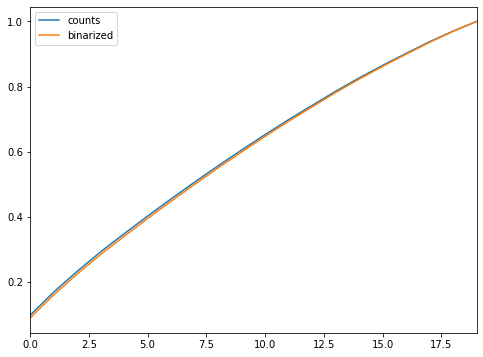

In [34]:
fig, ax = plt.subplots(figsize=(8,6))

pca_sparse_df.plot(ax = ax)

It seems there is little to no difference in the increase of explainability per additional feature between counts and bins.

We'll take counts forward to model selection.

In [35]:
combined_features = FeatureUnion([
    (
        "generate_features",
        generate_features
    ),
    (
        "count_pairs",
        count_pairs,
    )    
])

In [36]:
combined_pipeline = Pipeline([
    (
        "combined_features",
        combined_features
    ),
    (
        "standard_scaler",
        StandardScaler()
    ),
    (
        "pca",
        PCA(),
    ) 
])

In [37]:
combined_X = combined_pipeline.fit_transform(X)

In [38]:
combined_features_names = combined_features.get_feature_names()
print(combined_features_names)

['generate_features__digit_ratio__domain_digit_ratio', 'generate_features__vowel_ratio__domain_vowel_ratio', 'generate_features__vowel_distance_std_ratio__domain_vowel_distance_std_ratio', 'generate_features__vowel_distance_mode_ratio__domain_vowel_distance_mode_ratio', 'generate_features__consonants_variety_ratio__domain_consonants_variety_ratio', 'generate_features__len__domain_len', 'count_pairs__domain_count_pair_al', 'count_pairs__domain_count_pair_an', 'count_pairs__domain_count_pair_ar', 'count_pairs__domain_count_pair_en', 'count_pairs__domain_count_pair_er', 'count_pairs__domain_count_pair_es', 'count_pairs__domain_count_pair_in', 'count_pairs__domain_count_pair_le', 'count_pairs__domain_count_pair_li', 'count_pairs__domain_count_pair_ma', 'count_pairs__domain_count_pair_me', 'count_pairs__domain_count_pair_ne', 'count_pairs__domain_count_pair_on', 'count_pairs__domain_count_pair_or', 'count_pairs__domain_count_pair_ra', 'count_pairs__domain_count_pair_re', 'count_pairs__domai

## Model Evaluation

Given our potential datasets:
* Features we've generated from `domain`
* Character pair counts in `domain`
* The combination of the above

Let's test them on some naive models to see their performance.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_X, y,
    test_size = 0.3,
    random_state = 42,
    stratify = y,
)

In [40]:
def naive_model_evaluation(
    X_train, y_train,
    X_test, y_test,
    tuning_param_values,
    get_model,
    get_model_complexity = None,
):
    
    models = dict()
    
    col_names = [
        'type', 'hyper_param_val', 'complexity', "accuracy_score", 
        "precision_score", "recall_score", "f1_score", "fit_time_in_seconds"
    ]

    metrics = np.zeros((len(Cs), len(col_names)))
    metrics[:,1] = tuning_param_values

    for index, value in enumerate(tuning_param_values):
        model = get_model(value)

        fit_start = time()
        model.fit(X_train, y_train)
        fit_time_in_seconds = float(time() - fit_start)
        
        models[value] = model

        test_predictions = model.predict(X_test)
        
        if get_model_complexity is not None:
            metrics[index, 2] = get_model_complexity(model)
        else:
            metrics[index, 2] = np.nan
                
        metrics[index, 3] = accuracy_score(y_test, test_predictions)
        metrics[index, 4] = precision_score(y_test, test_predictions)
        metrics[index, 5] = recall_score(y_test, test_predictions)
        metrics[index, 6] = f1_score(y_test, test_predictions)
        metrics[index, 7] = fit_time_in_seconds


    metrics_df = pd.DataFrame(metrics, columns=col_names)
    metrics_df["type"] = type(model).__name__
    
    display(metrics_df)
    
    return models, metrics_df   
    

In [41]:
NUMER_OF_ITERATIONS = 5

In [42]:
Cs = np.linspace(0.0001, 1.0, NUMER_OF_ITERATIONS)

In [43]:
from sklearn.linear_model import LogisticRegression

def get_logistic_reg(c):
    return LogisticRegression(
        class_weight="balanced", 
        random_state = 42,
        penalty = 'l1',
        C = c,        
        solver = "liblinear",
    )

def get_logistic_reg_complexity(model):
    return np.count_nonzero(model.coef_)

logistic_regressors, logistic_regressors_df = naive_model_evaluation(
    X_train, y_train,
    X_test, y_test,
    Cs, get_logistic_reg, get_logistic_reg_complexity,
)

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,LogisticRegression,0.000100,1.0,0.835904,0.840897,0.858659,0.849685,0.169497
1,LogisticRegression,0.250075,26.0,0.884830,0.890088,0.897618,0.893837,0.297498
2,LogisticRegression,0.500050,26.0,0.884801,0.890082,0.897564,0.893808,0.301997
3,LogisticRegression,0.750025,26.0,0.884801,0.890082,0.897564,0.893808,0.306500
4,LogisticRegression,1.000000,26.0,0.884830,0.890088,0.897618,0.893837,0.280498


In [44]:
from sklearn.svm import LinearSVC

def get_svc(c):
    return LinearSVC(
        class_weight="balanced",
        random_state = 42,
        penalty = 'l2',
        C = c,
        max_iter = 10000,
    )

def get_svc_complexity(model):
    return np.count_nonzero(model.coef_)

svcs, svcs_df = naive_model_evaluation(
    X_train, y_train,
    X_test, y_test,
    Cs, get_svc, get_svc_complexity,
)

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,LinearSVC,0.000100,26.0,0.883113,0.877950,0.910120,0.893745,0.313997
1,LinearSVC,0.250075,26.0,0.883579,0.885663,0.900744,0.893140,30.597517
2,LinearSVC,0.500050,26.0,0.883579,0.885663,0.900744,0.893140,76.535519
3,LinearSVC,0.750025,26.0,0.883579,0.885663,0.900744,0.893140,129.083517
4,LinearSVC,1.000000,26.0,0.883579,0.885663,0.900744,0.893140,138.360981


In [45]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = np.linspace(5, 2500, NUMER_OF_ITERATIONS, dtype=int)

def get_random_forrest(n):
    return RandomForestClassifier(
        n_estimators=n,
        class_weight="balanced",
        random_state=42,
        n_jobs = -1,
    )

rfs, rfs_df = naive_model_evaluation(
    X_train, y_train,
    X_test, y_test,
    n_estimators, get_random_forrest, None,
)

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,RandomForestClassifier,5.0,NaN,0.925403,0.924473,0.938571,0.931469,1.458681
1,RandomForestClassifier,628.0,NaN,0.935503,0.930234,0.951988,0.940985,60.220703
2,RandomForestClassifier,1252.0,NaN,0.935590,0.930789,0.951503,0.941032,133.261000
3,RandomForestClassifier,1876.0,NaN,0.935706,0.930713,0.951827,0.941151,221.644998
4,RandomForestClassifier,2500.0,NaN,0.935823,0.930773,0.951988,0.941261,330.311500


In [46]:
from sklearn.neighbors import KNeighborsClassifier

# smaller values of k are more complex models
n_neighbours = np.flip(np.linspace(3, 600, 5, dtype=int))

def get_knn(n):
    return KNeighborsClassifier(
            n_neighbors = n,
            n_jobs = -1
        )

knns, knn_df = naive_model_evaluation(
    X_train, y_train,
    X_test, y_test,
    n_neighbours, get_knn, None,
)

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,KNeighborsClassifier,600.0,NaN,0.858374,0.810082,0.963735,0.880254,1.075998
1,KNeighborsClassifier,450.0,NaN,0.870278,0.825794,0.962981,0.889127,0.788000
2,KNeighborsClassifier,301.0,NaN,0.883579,0.846718,0.957862,0.898867,0.949997
3,KNeighborsClassifier,152.0,NaN,0.893329,0.862413,0.954844,0.906278,0.872002
4,KNeighborsClassifier,3.0,NaN,0.902410,0.899019,0.922998,0.910851,0.960001


In [47]:
all_models_df = pd.concat([
    logistic_regressors_df,
    svcs_df,
    rfs_df,
    knn_df,
])

In [48]:
all_models_df["type"].unique()

array(['LogisticRegression', 'LinearSVC', 'RandomForestClassifier',
       'KNeighborsClassifier'], dtype=object)

In [79]:
def display_top_quartile_scores(all_models_df, column, smaller_is_better = False, groupby = "type", unstack = True):
    column_scores = all_models_df[column].describe()    
    
    report_df = all_models_df[all_models_df[column] >= column_scores["75%"]].sort_values(column, ascending = False)
    
    if smaller_is_better:
        report_df = all_models_df[all_models_df[column] <= column_scores["25%"]].sort_values(column, ascending = True)
    
    display(report_df.reset_index(drop=True))
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    if unstack:
        plot_score_df = all_models_df[[groupby,column]].groupby(groupby).apply(lambda x: x.unstack()).drop(groupby, axis = 1).T
        plot_score_df.columns = plot_score_df.columns.get_level_values(0)
    else:
        plot_score_df = all_models_df[[groupby,column]].set_index(groupby)
    
    plot_score_df = plot_score_df.reset_index(drop = True)
    return plot_score_df.plot(ax = ax)

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,RandomForestClassifier,2500.0,NaN,0.935823,0.930773,0.951988,0.941261,330.311500
1,RandomForestClassifier,1876.0,NaN,0.935706,0.930713,0.951827,0.941151,221.644998
2,RandomForestClassifier,1252.0,NaN,0.935590,0.930789,0.951503,0.941032,133.261000
3,RandomForestClassifier,628.0,NaN,0.935503,0.930234,0.951988,0.940985,60.220703
4,RandomForestClassifier,5.0,NaN,0.925403,0.924473,0.938571,0.931469,1.458681


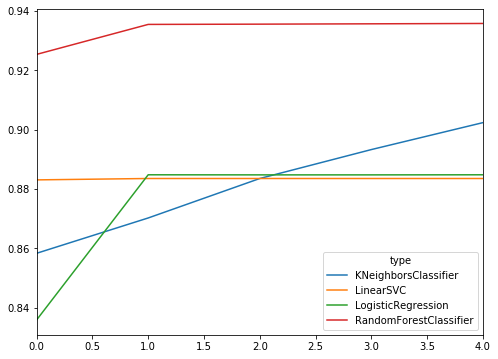

In [50]:
display_top_quartile_scores(all_models_df, "accuracy_score")

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,RandomForestClassifier,1252.0,NaN,0.935590,0.930789,0.951503,0.941032,133.261000
1,RandomForestClassifier,2500.0,NaN,0.935823,0.930773,0.951988,0.941261,330.311500
2,RandomForestClassifier,1876.0,NaN,0.935706,0.930713,0.951827,0.941151,221.644998
3,RandomForestClassifier,628.0,NaN,0.935503,0.930234,0.951988,0.940985,60.220703
4,RandomForestClassifier,5.0,NaN,0.925403,0.924473,0.938571,0.931469,1.458681


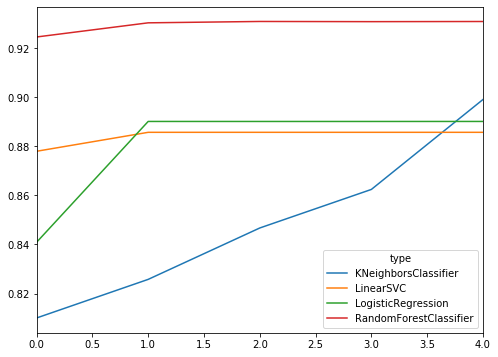

In [51]:
display_top_quartile_scores(all_models_df, "precision_score")

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,KNeighborsClassifier,600.0,NaN,0.858374,0.810082,0.963735,0.880254,1.075998
1,KNeighborsClassifier,450.0,NaN,0.870278,0.825794,0.962981,0.889127,0.788000
2,KNeighborsClassifier,301.0,NaN,0.883579,0.846718,0.957862,0.898867,0.949997
3,KNeighborsClassifier,152.0,NaN,0.893329,0.862413,0.954844,0.906278,0.872002
4,RandomForestClassifier,628.0,NaN,0.935503,0.930234,0.951988,0.940985,60.220703
5,RandomForestClassifier,2500.0,NaN,0.935823,0.930773,0.951988,0.941261,330.311500


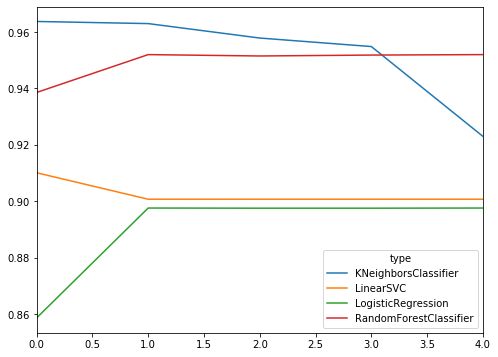

In [52]:
display_top_quartile_scores(all_models_df, "recall_score")

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,RandomForestClassifier,2500.0,NaN,0.935823,0.930773,0.951988,0.941261,330.311500
1,RandomForestClassifier,1876.0,NaN,0.935706,0.930713,0.951827,0.941151,221.644998
2,RandomForestClassifier,1252.0,NaN,0.935590,0.930789,0.951503,0.941032,133.261000
3,RandomForestClassifier,628.0,NaN,0.935503,0.930234,0.951988,0.940985,60.220703
4,RandomForestClassifier,5.0,NaN,0.925403,0.924473,0.938571,0.931469,1.458681


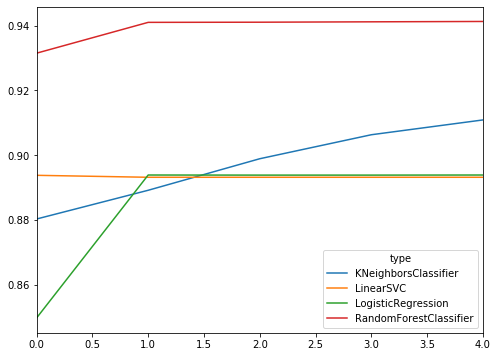

In [53]:
display_top_quartile_scores(all_models_df, "f1_score")

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,LogisticRegression,0.000100,1.0,0.835904,0.840897,0.858659,0.849685,0.169497
1,LogisticRegression,1.000000,26.0,0.884830,0.890088,0.897618,0.893837,0.280498
2,LogisticRegression,0.250075,26.0,0.884830,0.890088,0.897618,0.893837,0.297498
3,LogisticRegression,0.500050,26.0,0.884801,0.890082,0.897564,0.893808,0.301997
4,LogisticRegression,0.750025,26.0,0.884801,0.890082,0.897564,0.893808,0.306500


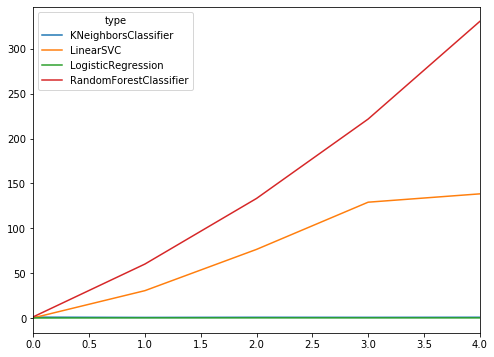

In [54]:
display_top_quartile_scores(all_models_df, "fit_time_in_seconds", True)

Consider all of the above, it seems our RandomForrest with 628 estimators is a viable candidate.

In [55]:
candidate_model = rfs[628]

One attribute of forrest based models is they are able to report the relative importance of the features used in building the forrest.

In [56]:
def get_importances(estimator, X_columns):
    return pd.Series(estimator.feature_importances_, index = X_columns).sort_values(ascending = False)

In [57]:
candiate_importances = get_importances(candidate_model, combined_features_names)
print(candiate_importances)
print("len(candiate_importances)", len(candiate_importances))

generate_features__digit_ratio__domain_digit_ratio                                0.344165
count_pairs__domain_count_pair_ti                                                 0.124021
generate_features__vowel_ratio__domain_vowel_ratio                                0.086099
count_pairs__domain_count_pair_on                                                 0.054307
count_pairs__domain_count_pair_ar                                                 0.048866
generate_features__consonants_variety_ratio__domain_consonants_variety_ratio      0.039594
count_pairs__domain_count_pair_to                                                 0.025686
count_pairs__domain_count_pair_re                                                 0.021711
count_pairs__domain_count_pair_or                                                 0.020197
count_pairs__domain_count_pair_te                                                 0.019593
generate_features__len__domain_len                                                0.019592

Let's evaluate our candidate model and another model that we'll build with the same number of estimators but using a reduced number of features.

In [58]:
def display_confusion_matrix(y_actual, y_predictions, class_names):
    
    cm = confusion_matrix(y_actual, y_predictions)
    
    df_cm = pd.DataFrame(
        cm, index = class_names, columns = class_names, 
    )
    
    figsize = (10,7)
    fontsize=14    
    
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [59]:
def evaluate_model(model, X_train, y_train, X_test, y_test, class_names):
    
    train_predictions = model.predict(X_train)
    print("Training Report")
    print(classification_report(y_train, train_predictions))
    
    test_predictions = model.predict(X_test)
    print("Test Report")
    print(classification_report(y_test, test_predictions))
    
    display_confusion_matrix(y_test, test_predictions, class_names)

Training Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     36865
           1       0.98      0.98      0.98     43302

    accuracy                           0.98     80167
   macro avg       0.98      0.98      0.98     80167
weighted avg       0.98      0.98      0.98     80167

Test Report
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     15800
           1       0.93      0.95      0.94     18558

    accuracy                           0.94     34358
   macro avg       0.94      0.93      0.93     34358
weighted avg       0.94      0.94      0.94     34358



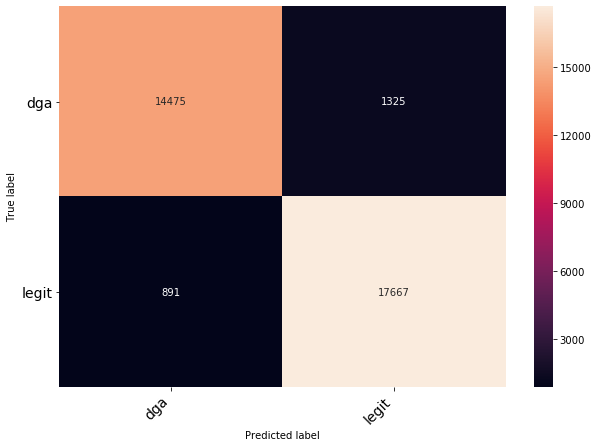

In [60]:
evaluate_model(candidate_model, X_train, y_train, X_test, y_test, class_le.classes_)

While we've already extracted the feature importances as fitted in our candidate model, another approach is to use Recursive Feature Elimination. We achive this fitting a number of models and gradually reducing the number of features progressively until we've reached the target number of features.

This gives a means of ranking of the most important features.

In [61]:
from sklearn.feature_selection import RFE

rfe = RFE(candidate_model, n_features_to_select=1, verbose = 1)
rfe = rfe.fit(X_train, y_train)

Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


In [62]:
print("Features sorted by their rank:")
combined_feature_rfe_importances = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), combined_features_names))
combined_feature_rfe_importances

Features sorted by their rank:


[(1, 'generate_features__digit_ratio__domain_digit_ratio'),
 (2, 'count_pairs__domain_count_pair_ti'),
 (3, 'generate_features__vowel_ratio__domain_vowel_ratio'),
 (4, 'count_pairs__domain_count_pair_ar'),
 (5, 'count_pairs__domain_count_pair_on'),
 (6,
  'generate_features__consonants_variety_ratio__domain_consonants_variety_ratio'),
 (7, 'count_pairs__domain_count_pair_re'),
 (8, 'count_pairs__domain_count_pair_to'),
 (9, 'count_pairs__domain_count_pair_te'),
 (10, 'generate_features__len__domain_len'),
 (11, 'count_pairs__domain_count_pair_le'),
 (12,
  'generate_features__vowel_distance_std_ratio__domain_vowel_distance_std_ratio'),
 (13, 'count_pairs__domain_count_pair_or'),
 (14, 'count_pairs__domain_count_pair_me'),
 (15, 'count_pairs__domain_count_pair_in'),
 (16,
  'generate_features__vowel_distance_mode_ratio__domain_vowel_distance_mode_ratio'),
 (17, 'count_pairs__domain_count_pair_st'),
 (18, 'count_pairs__domain_count_pair_ne'),
 (19, 'count_pairs__domain_count_pair_ma'),
 

Given the above let's refit our candidate model, using the above information.

In [63]:
get_random_forrest(628)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=628,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [64]:
combined_X_df = pd.DataFrame(
    combined_X, columns = combined_features.get_feature_names()
)

In [65]:
rfe_rfs = dict()

In [66]:
[x[1] for x in combined_feature_rfe_importances][:1]

['generate_features__digit_ratio__domain_digit_ratio']

In [67]:
rfe_rfs = dict()

col_names = [
    "feature_count", "accuracy_score", 
    "precision_score", "recall_score", "f1_score", "fit_time_in_seconds"
]

feature_range = list(range(1, len(combined_feature_rfe_importances)))

metrics = np.zeros((len(feature_range), len(col_names)))
metrics[:,0] = feature_range

for i in range(1,len(feature_range)):
    columns = [x[1] for x in combined_feature_rfe_importances][:i+1]

    # really inefficient could do masking to get the columns I want
    combined_X_train, combined_X_test, combined_y_train, combined_y_test = train_test_split(
        combined_X_df[columns].values, y,
        test_size = 0.3,
        random_state = 42,
        stratify = y,
    )
    
    model = get_random_forrest(628)  

    fit_start = time()
    model.fit(combined_X_train, combined_y_train)
    fit_time_in_seconds = float(time() - fit_start)

    rfe_rfs[i] = model

    test_predictions = model.predict(combined_X_test)

    metrics[i, 1] = accuracy_score(combined_y_test, test_predictions)
    metrics[i, 2] = precision_score(combined_y_test, test_predictions)
    metrics[i, 3] = recall_score(combined_y_test, test_predictions)
    metrics[i, 4] = f1_score(combined_y_test, test_predictions)
    metrics[i, 5] = fit_time_in_seconds
    
metrics_df = pd.DataFrame(metrics, columns=col_names)

display(metrics_df)

,feature_count,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.0,0.906106,0.899312,0.930327,0.914557,30.585483
2,3.0,0.926334,0.922809,0.942451,0.932526,35.618983
3,4.0,0.927353,0.924023,0.943043,0.933436,49.044996
4,5.0,0.929303,0.925635,0.945037,0.935235,42.955584
5,6.0,0.931370,0.927576,0.946869,0.937123,42.835363
6,7.0,0.932388,0.927755,0.948701,0.938111,40.584491
7,8.0,0.938530,0.936326,0.950857,0.943535,42.064000
8,9.0,0.939112,0.936949,0.951288,0.944064,60.324625
9,10.0,0.938471,0.936088,0.951018,0.943494,67.786226


In [87]:
metrics_df = metrics_df.loc[1:]

,feature_count,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,9.0,0.939112,0.936949,0.951288,0.944064,60.324625
1,11.0,0.938995,0.935918,0.952258,0.944017,56.093482
2,8.0,0.938530,0.936326,0.950857,0.943535,42.064000
3,10.0,0.938471,0.936088,0.951018,0.943494,67.786226
4,12.0,0.938122,0.934525,0.952150,0.943255,62.353501
5,16.0,0.938122,0.934204,0.952527,0.943276,83.416404


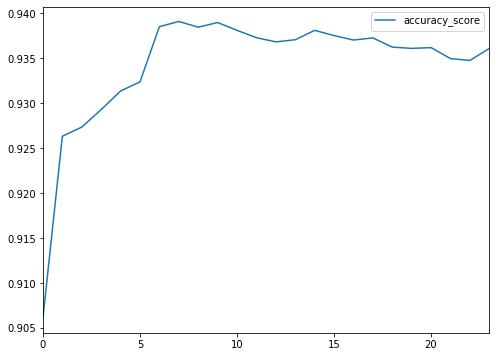

In [96]:
display_top_quartile_scores(metrics_df, "accuracy_score", groupby = "feature_count", unstack = False)

,feature_count,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,9.0,0.939112,0.936949,0.951288,0.944064,60.324625
1,8.0,0.938530,0.936326,0.950857,0.943535,42.064000
2,10.0,0.938471,0.936088,0.951018,0.943494,67.786226
3,11.0,0.938995,0.935918,0.952258,0.944017,56.093482
4,12.0,0.938122,0.934525,0.952150,0.943255,62.353501
5,16.0,0.938122,0.934204,0.952527,0.943276,83.416404


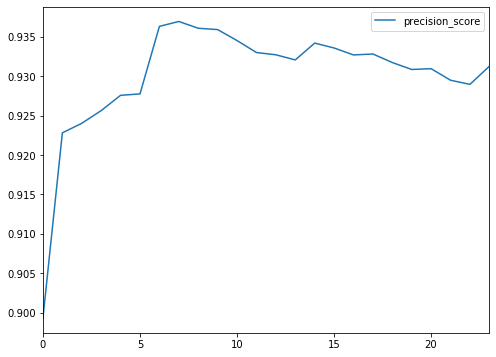

In [89]:
display_top_quartile_scores(metrics_df, "precision_score", groupby = "feature_count", unstack = False)

,feature_count,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,15.0,0.937074,0.932065,0.952958,0.942396,73.598385
1,16.0,0.938122,0.934204,0.952527,0.943276,83.416404
2,22.0,0.936201,0.930956,0.952527,0.941618,109.974744
3,19.0,0.937278,0.932820,0.952473,0.942544,88.425522
4,21.0,0.936114,0.930855,0.952473,0.941540,103.998980
5,13.0,0.937307,0.933006,0.952312,0.942560,64.275006


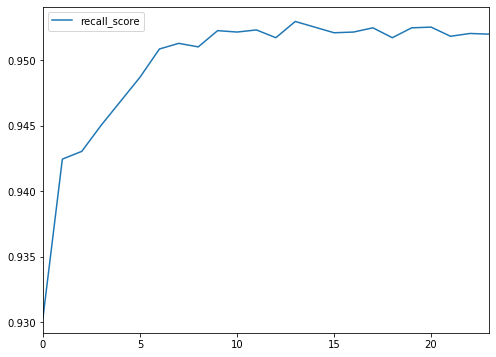

In [90]:
display_top_quartile_scores(metrics_df, "recall_score", groupby = "feature_count", unstack = False)

,feature_count,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,9.0,0.939112,0.936949,0.951288,0.944064,60.324625
1,11.0,0.938995,0.935918,0.952258,0.944017,56.093482
2,8.0,0.938530,0.936326,0.950857,0.943535,42.064000
3,10.0,0.938471,0.936088,0.951018,0.943494,67.786226
4,16.0,0.938122,0.934204,0.952527,0.943276,83.416404
5,12.0,0.938122,0.934525,0.952150,0.943255,62.353501


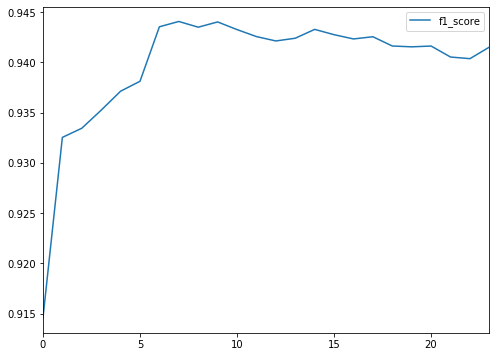

In [91]:
display_top_quartile_scores(metrics_df, "f1_score", groupby = "feature_count", unstack = False)

,feature_count,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,2.0,0.906106,0.899312,0.930327,0.914557,30.585483
1,3.0,0.926334,0.922809,0.942451,0.932526,35.618983
2,7.0,0.932388,0.927755,0.948701,0.938111,40.584491
3,8.0,0.938530,0.936326,0.950857,0.943535,42.064000
4,6.0,0.931370,0.927576,0.946869,0.937123,42.835363
5,5.0,0.929303,0.925635,0.945037,0.935235,42.955584


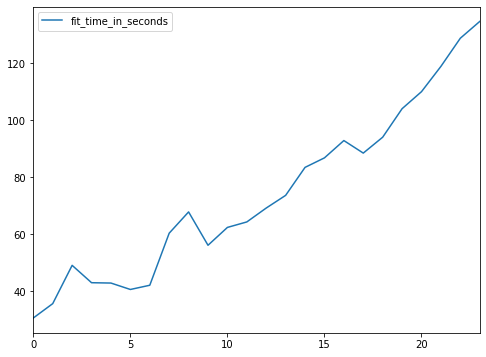

In [92]:
display_top_quartile_scores(metrics_df, "fit_time_in_seconds", True, "feature_count", unstack = False)

Unsuprisingly the fit time increases with the number of features. Less features means less time to train.

Given our models with 9 and 15 features are best performers based on the metrics we've selected, lets visualise the differences.

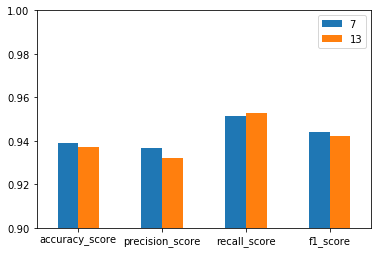

In [144]:
metrics_df[metrics_df["feature_count"].isin([9,15])][[
    "accuracy_score", "precision_score", "recall_score", "f1_score"
]].T.plot.bar(ylim=(0.9, 1.0), rot =0)

These will be the features we carry forward.

In [159]:
grid_search_columns = [x[1] for x in combined_feature_rfe_importances][:9]
grid_search_columns

['generate_features__digit_ratio__domain_digit_ratio',
 'count_pairs__domain_count_pair_ti',
 'generate_features__vowel_ratio__domain_vowel_ratio',
 'count_pairs__domain_count_pair_ar',
 'count_pairs__domain_count_pair_on',
 'generate_features__consonants_variety_ratio__domain_consonants_variety_ratio',
 'count_pairs__domain_count_pair_re',
 'count_pairs__domain_count_pair_to',
 'count_pairs__domain_count_pair_te']

In [161]:
# really inefficient could do masking to get the columns I want
grid_X_train, grid_X_test, grid_y_train, grid_y_test = train_test_split(
    combined_X_df[keep_columns].values, y,
    test_size = 0.3,
    random_state = 42,
    stratify = y,
)


In [162]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [ ]:
rf = RandomForestClassifier(
    bootstrap = True,
    criterion = "gini",
    max_features = "sqrt",
    class_weight = "balanced_subsample",
    oob_score = False,
    random_state = 42,
)

In [178]:
param_grid = {
    "max_depth": np.linspace(5, 50, 3, dtype = int),
    "n_estimators": np.linspace(25, 628, 8, dtype = int),
    "min_samples_split": np.linspace(5, 30, 3, dtype = int),
    "min_samples_leaf": np.linspace(2, 16, 3, dtype = int),
}

In [179]:
CV_rf = GridSearchCV(
    rf,
    param_grid,
    scoring="f1_micro",
    n_jobs=-1,
    cv=2,
    refit=True,
    verbose=1,
    error_score="raise",
    return_train_score=False,
)

In [180]:
CV_rf.fit(grid_X_train, grid_y_train)

Fitting 2 folds for each of 216 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 60.6min finished


GridSearchCV(cv=2, error_score='raise',
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimat...s=-1,
                                              oob_score=False, random_state=42,
                           

In [181]:
print(CV_rf.best_params_)

{'max_depth': 27, 'min_samples_leaf': 2, 'min_samples_split': 17, 'n_estimators': 369}


In [182]:
best_grid_rf = CV_rf.best_estimator_

Training Report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     36865
           1       0.96      0.97      0.97     43302

    accuracy                           0.96     80167
   macro avg       0.96      0.96      0.96     80167
weighted avg       0.96      0.96      0.96     80167

Test Report
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     15800
           1       0.94      0.95      0.94     18558

    accuracy                           0.94     34358
   macro avg       0.94      0.94      0.94     34358
weighted avg       0.94      0.94      0.94     34358



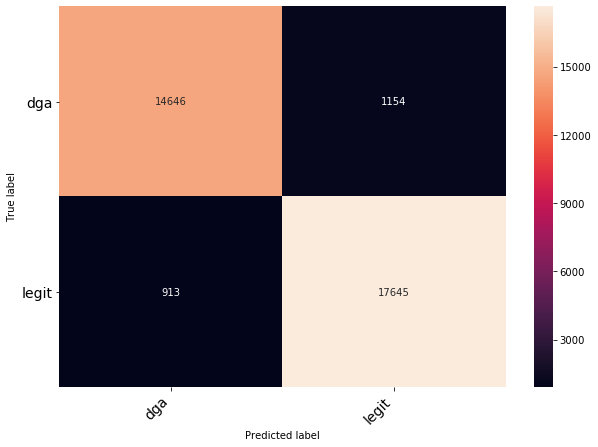

In [183]:
evaluate_model(
    best_grid_rf, 
    grid_X_train, grid_y_train, 
    grid_X_test, grid_y_test, 
    class_le.classes_
)